In [1]:
from IPython.core.display import display

from collections import OrderedDict
import copy
import pandas
import pickle
import pytool
import matplotlib.pyplot as plt
%matplotlib inline

from tariff import Tariff
from tariff.bill_calculator import BillCalculator
from optimizer_engine.optimizer import Optimizer

## Configuration

[**USER INPUT REQUIRED**] Set the **site ID**:

In [2]:
site = 'wmec'

Create `Tariff` calculator

In [3]:
tariff = Tariff(site)
tz = tariff.timezone

[**USER INPUT REQUIRED**] Set the **start** and **end** datas:

In [4]:
start = '2019-06-03 00:00'
end = '2019-07-01 23:59'

Create `DateTime` objects

In [5]:
start = tz.localize(pandas.to_datetime(start))
end = tz.localize(pandas.to_datetime(end))

[**USER INPUT REQUIRED**] Specify **load** and **weather** data:

In [6]:
baseline_filename = #'inputs/wmec_perfest_replay_complete_20190502_to_20190602.pickle'
temperature_filename = #'inputs/wmec_weather_20190502_to_20190602.pickle'

### Load baseline and temperature data

In [7]:
with open(baseline_filename, 'rb') as baseline_file:
    load = pickle.load(baseline_file)
    load = pandas.DataFrame(load['values'], columns=load['columns'])
    load.time = load.time.apply(lambda t: pytool.time.fromutctimestamp(t/1e6))
    load.set_index('time', drop=True, inplace=True)
    load = load.resample("15T").mean()

> **NOTE**: This is to use `building.net` as the "actual" building power

### Load Weather Data

In [36]:
with open(temperature_filename, 'rb') as temperature_file:
    temperature = pickle.load(temperature_file)
    temperature = pandas.DataFrame(temperature['values'], columns=temperature['columns'])
    temperature.time = temperature.time.apply(lambda t: pytool.time.fromutctimestamp(t/1e6))  
    temperature.set_index('time', drop=True, inplace=True)
    temperature = temperature.resample("15T").mean()

> **NOTE**: This is to use oat_fms_roof since it is more accurate than DarkSky temperature

In [12]:
temperature['temperature'] = temperature['oat_fms_roof']*9/5 + 32

Merge and clean baseline and weather data

In [13]:
load = load.merge(temperature, how='left',
                  left_index=True, right_index=True)
load[['building.baseline.power.kW', 'building.actual.power.kW', 'crs.baseline.power.kW', 'temperature']].interpolate(method='time')
load = load.interpolate(method='time')
load = load.fillna(method='bfill')
load = load.assign(time=load.index)
load = tariff.apply_season(load, time_column='time')
load = tariff.apply_period(load, time_column='time')

Create the configuration for the *Optimizer*

In [14]:
config = {
    "site_id": site,
    "start": start,
    "end": end,
    "RB_capacity": 1394,
    "MCL": 60,
    "MDL": 130,
    "MRC": 120,
    "M": 1000,
    "min_charge_offset": 5,
    "min_discharge_offset": 5,
    "heat_leak_coefficients": [3.113803761194959, 0.11538188719459914, 9.075501370403584e-06],
    "cop_dchg_coefficients": [13.501716350835526, -0.4872050227894297, 0.005329472373599393],
    "cop_chg_coefficients": [2.1921996373327572, -0.01840263947479562, -0.00010573043729772588],
    "SOC_initial": 250,
    "SOC_final": 250,
    "constraints": {
        "time_transition": True,
        "minimum_charge_offset": False,
        "minimum_discharge_offset": False,
        "chg_limit_curve": True,
        "dchg_limit_curve": True,
        "fixed_rte": False
    },
    "outputs": {
        "timestamp": True,
        "baseline": True,
        "offsets": True,
        "load_values": True,
        "soc": True,
        "charge_limits": True,
        "discharge_limits": True,
        "cop_dchg": True,
        "cop_chg": True,
        "temperature": True
    }
}

## Utility Functions

In [15]:
def update_timestamps(config, *args):
    """
    Mutate *config* with the timestamp ranges from the passed dataframes

    :param dict config: Config dictionary generated by input_config
    :return dict: Configuration dictionary updated
    """
    start_ts = config['start']
    end_ts = config['end']
    timezone = start_ts.tzinfo

    start_ts = start_ts.replace(tzinfo=None)
    end_ts = end_ts.replace(tzinfo=None)

    start = start_ts
    end = end_ts

    for frame in args:
        stamp = frame.iloc[0].timestamp.to_pydatetime()

        if stamp.tzinfo is not None:
            stamp = stamp.astimezone(timezone)
            stamp = stamp.replace(tzinfo=None)

        if stamp > start:
            start = stamp

        stamp = frame.iloc[-1].timestamp.to_pydatetime()
        if stamp.tzinfo is not None:
            stamp = stamp.astimezone(timezone)
            stamp = stamp.replace(tzinfo=None)

        if stamp < end:
            end = stamp

    config['start'] = start.replace(tzinfo=timezone)
    config['end'] = end.replace(tzinfo=timezone)

    return config

In [16]:
def update_dataframes(config, baseline, actual, crs_power, temperature):
    """
    Subset & return dataframes with updated timestamp values

    :param dict config: Configuration dictionary
    :param DataFrame building_power: Building power time series data
    :param DataFrame crs_power: CRS power time series data
    :param DataFrame temperature: Temperature time series data
    :return tuple: Building power, CRS power and temperature data frames
    """
    start = config['start']
    end = config['end']

    baseline = baseline.loc[(baseline.timestamp >= start) &
                            (baseline.timestamp <= end)]

    actual = actual.loc[(actual.timestamp >= start) &
                        (actual.timestamp <= end)]

    crs_power = crs_power.loc[(crs_power.timestamp >= start) &
                              (crs_power.timestamp <= end)]

    temperature = temperature.loc[(temperature.timestamp >= start) &
                                  (temperature.timestamp <= end)]

    print("Length of optimization window {}".format(len(temperature)))

    return baseline, actual, crs_power, temperature

In [17]:
def run_optimizer(config, bl, crs, temp):
    """
    Return an optimized operating schedule for the given input data to
    determine ideal savings figures

    :param dict config: Optimizer configuration
    :param pandas.DataFrame bl: Building power load values
    :param pandas.DataFrame crs: CRS power load values
    :param pandas.DataFrame temp: Temperature values
    :return: Optimized load values and offsets
    """
    bl = bl.rename(columns={'load_values': 'building_baseline'})
    crs = crs.rename(columns={'load_values': 'crs_baseline'})
    input_df = bl.merge(crs, on='timestamp')
    input_df = input_df.merge(temp, on='timestamp')

    opt = Optimizer(config)
    target_df = opt.solve(input_df)

    return target_df

In [18]:
def plot(config, targets):
    suptitle = "Optimizer Outputs"
    title = 'Baselines, Targets, Offsets, and SOC'

    fig,ax = plt.subplots(figsize = (20,10))
    plt.suptitle(suptitle, fontsize = 22)
    plt.title(title, fontsize = 18)

    #plotting power related graphs on first y axis
    ln1 = ax.plot(targets.timestamp, targets.offsets, label = "Offset");
    ln2 = ax.plot(targets.timestamp, targets.baseline, label = 'Building Power');
    ln3 = ax.plot(targets.timestamp, targets.load_values, label = 'New Building Power');
    ln4 = ax.plot(targets.timestamp, -targets.charge_limits, label = 'Max Charge Values');
    ln5 = ax.plot(targets.timestamp, targets.discharge_limits, label = 'Max Discharge Values');
    ln6 = ax.axhline(y=-config['MCL'], label = "Max Charge Cap", color = 'forestgreen');

    ax.set_xlabel('Time period')
    ax.set_ylabel('Power in KW')

    ax2 = ax.twinx();
    ln6 = ax2.plot(targets.timestamp, targets.soc, '--',label = "SOC");

    ax2.set_ylabel('State of charge in KWht')

    ax.axhline(0, color = 'black');
    #Managing labels and legend
    lns = ln1 + ln2 + ln3 + ln4 + ln5 + ln6
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best');

## Savings Calculator

In [19]:
bl = load[['time', 'building.baseline.power.kW']].reset_index(drop=True)
al = load[['time', 'building.actual.power.kW']].reset_index(drop=True)
crs = load[['time', 'crs.baseline.power.kW']].reset_index(drop=True)
temp = load[['time', 'temperature']]

bl.columns = ['timestamp', 'load_values']
al.columns = ['timestamp', 'load_values']
crs.columns = ['timestamp', 'load_values']
temp.columns = ['timestamp', 'temperature']

config = update_timestamps(config, bl, al, crs, temp)
bl, al, crs, temp = update_dataframes(config, bl, al, crs, temp)

targets = run_optimizer(config, bl, crs, temp)

new_loads = targets[['timestamp', 'load_values']]

# Actual RTE calc:
diff = bl.load_values - al.load_values
actual_rte = diff[diff > 0].sum() / -diff[diff < 0].sum()

# Ideal RTE Calc:
DCHG = targets[targets.offsets > 0]['offsets'].sum()
CHG = targets[targets.offsets < 0]['offsets'].sum()
ideal_rte = DCHG / -CHG

bill_calculator = BillCalculator(config['site_id'])

# Baseline Bill split analysis
baseline_demand_bill = bill_calculator.calculate_demand_bill(bl)
baseline_energy_bill = bill_calculator.calculate_energy_bill(bl)
baseline_energy_consumption_components = bill_calculator.calculate_energy_consumption_components(bl)
baseline_energy_bill_components = bill_calculator.calculate_energy_bill_components(bl)

# Actual Bill split analysis
actual_demand_bill = bill_calculator.calculate_demand_bill(al)
actual_energy_bill = bill_calculator.calculate_energy_bill(al)
actual_energy_consumption_components = bill_calculator.calculate_energy_consumption_components(al)
actual_energy_bill_components = bill_calculator.calculate_energy_bill_components(al)

# Ideal Bill split analysis
ideal_demand_bill = bill_calculator.calculate_demand_bill(new_loads)
ideal_energy_bill = bill_calculator.calculate_energy_bill(new_loads)
ideal_energy_consumption_components = bill_calculator.calculate_energy_consumption_components(new_loads)
ideal_energy_bill_components = bill_calculator.calculate_energy_bill_components(new_loads)

# Actual Savings
actual_demand_savings = baseline_demand_bill - actual_demand_bill
actual_energy_savings = baseline_energy_bill - actual_energy_bill

# Ideal Savings
ideal_demand_savings = baseline_demand_bill - ideal_demand_bill
ideal_energy_savings = baseline_energy_bill - ideal_energy_bill

# Total Savings
actual_total_savings = actual_demand_savings + actual_energy_savings
ideal_total_savings = ideal_demand_savings + ideal_energy_savings

savings = pandas.DataFrame(OrderedDict([
    ("ideal_demand", round(ideal_demand_savings, 2)),
    ("actual_demand", round(actual_demand_savings, 2)),
    ("ideal_energy", round(ideal_energy_savings, 2)),
    ("actual_energy", round(actual_energy_savings, 2)),
    ("ideal_total", round(ideal_total_savings, 2)),
    ("actual_total", round(actual_total_savings, 2)),
    ("ideal_rte", round(ideal_rte, 2)),
    ("actual_rte", round(actual_rte, 2)),
]), index=[''])

Length of optimization window 3072


/opt/conda/lib/python3.7/site-packages/tariff/bill_calculator.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  load['season'] = load[time_column].apply(self.tariff.season)
/opt/conda/lib/python3.7/site-packages/tariff/bill_calculator.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  load['period'] = load[time_column].apply(self.tariff.period)


In [20]:
demand_charges = tariff.demand_rates()
energy_charges = tariff.energy_rates()
baseline_demand_peaks = bill_calculator.demand_peaks(bl)
actual_demand_peaks = bill_calculator.demand_peaks(al)
ideal_demand_peaks = bill_calculator.demand_peaks(new_loads)

[**USER INPUT REQUIRED**] Set **derating factor**

In [21]:
derating_factor = 0.85

In [22]:
derated_savings = ideal_demand_savings*derating_factor

In [23]:
peaks = copy.deepcopy(ideal_demand_peaks)
derated_demand_bill = ideal_demand_bill
derated_targets = targets
derated_loads = derated_targets[['timestamp', 'load_values']]
while (baseline_demand_bill - derated_demand_bill) > derated_savings:
    for season in peaks:
        peaks[season]['Non-Coincident'] += 5

    config['peaks'] = peaks

    derated_targets = run_optimizer(config, bl, crs, temp)
    derated_loads = derated_targets[['timestamp', 'load_values']]
    derated_demand_bill = bill_calculator.calculate_demand_bill(derated_loads)

derated_ideal_demand_bill = bill_calculator.calculate_demand_bill(derated_loads)
derated_ideal_energy_bill = bill_calculator.calculate_energy_bill(derated_loads)
derated_ideal_energy_bill_components = bill_calculator.calculate_energy_consumption_components(derated_loads)
derated_ideal_energy_bill_components_cost = bill_calculator.calculate_energy_bill_components(derated_loads)
derated_ideal_demand_savings = baseline_demand_bill - derated_ideal_demand_bill
derated_ideal_energy_savings = baseline_energy_bill - derated_ideal_energy_bill
derated_ideal_total_savings = derated_ideal_demand_savings + derated_ideal_energy_savings

DCHG = derated_targets[derated_targets.offsets > 0]['offsets'].sum()
CHG = derated_targets[derated_targets.offsets < 0]['offsets'].sum()
derated_ideal_rte = DCHG / -CHG

derated_ideal_demand_peaks = bill_calculator.demand_peaks(derated_loads)

derated_savings_outputs = pandas.DataFrame(OrderedDict([
    ("ideal_demand", round(derated_ideal_demand_savings, 2)),
    ("actual_demand", round(actual_demand_savings, 2)),
    ("ideal_energy", round(derated_ideal_energy_savings, 2)),
    ("actual_energy", round(actual_energy_savings, 2)),
    ("ideal_total", round(derated_ideal_total_savings, 2)),
    ("actual_total", round(actual_total_savings, 2)),
    ("ideal_rte", round(derated_ideal_rte, 2)),
    ("actual_rte", round(actual_rte, 2)),
]), index=[''])

In [24]:
actual_savings_tables = {}
ideal_savings_tables = {}
derated_ideal_savings_tables = {}
for season in baseline_demand_peaks:
    actual = OrderedDict()
    ideal = OrderedDict()
    derated = OrderedDict()
    for period in actual_energy_consumption_components[season]:
        energy_charge = energy_charges[season][period]
        baseline_energy_consumption = baseline_energy_consumption_components[season][period]
        actual_energy_consumption = actual_energy_consumption_components[season][period]
        actual_energy_savings = (
            baseline_energy_bill_components[season][period] - actual_energy_bill_components[season][period]
        )
        ideal_energy_consumption = ideal_energy_consumption_components[season][period]
        ideal_energy_savings = (
            baseline_energy_bill_components[season][period] - ideal_energy_bill_components[season][period]
        )
        derated_ideal_energy_consumption = derated_ideal_energy_bill_components[season][period]
        derated_ideal_energy_savings = (
            baseline_energy_bill_components[season][period] - derated_ideal_energy_bill_components_cost[season][period]
        )
        actual["Energy " + period] = OrderedDict([
            ('Rate', round(energy_charge, 2)),
            ('Baseline', round(baseline_energy_consumption, 2)),
            ('Actual', round(actual_energy_consumption, 2)),
            ('Change From Baseline', round(actual_energy_consumption - baseline_energy_consumption, 2)),
            ('Savings', round(actual_energy_savings, 2))
        ])
        ideal["Energy " + period] = OrderedDict([
            ('Rate', round(energy_charge, 2)),
            ('Baseline', round(baseline_energy_consumption, 2)),
            ('Ideal', round(ideal_energy_consumption, 2)),
            ('Change From Baseline', round(ideal_energy_consumption - baseline_energy_consumption, 2)),
            ('Savings', round(ideal_energy_savings, 2))
        ])
        derated["Energy " + period] = OrderedDict([
            ('Rate', round(energy_charge, 2)),
            ('Baseline', round(baseline_energy_consumption, 2)),
            ('Derated Ideal', round(derated_ideal_energy_consumption, 2)),
            ('Change From Baseline', round(derated_ideal_energy_consumption - baseline_energy_consumption, 2)),
            ('Savings', round(derated_ideal_energy_savings, 2))
        ])
    for period in baseline_demand_peaks[season]:
        demand_charge = demand_charges[season][period]
        baseline_peak = baseline_demand_peaks[season][period]
        actual_peak = actual_demand_peaks[season][period]
        ideal_peak = ideal_demand_peaks[season][period]
        derated_ideal_peak = derated_ideal_demand_peaks[season][period]
        actual_peak_reduction = actual_peak - baseline_peak
        ideal_peak_reduction = ideal_peak - baseline_peak
        derated_ideal_peak_reduction = derated_ideal_peak - baseline_peak
        actual["Demand " + period] = OrderedDict([
            ('Rate', demand_charge),
            ('Baseline', round(baseline_peak, 2)),
            ('Actual', round(actual_peak, 2)),
            ('Change From Baseline', round(actual_peak_reduction, 2)),
            ('Savings', round(abs(demand_charge*actual_peak_reduction), 2))
        ])
        ideal["Demand " + period] = OrderedDict([
            ('Rate', demand_charge),
            ('Baseline', round(baseline_peak, 2)),
            ('Ideal', round(ideal_peak, 2)),
            ('Change From Baseline', round(ideal_peak_reduction, 2)),
            ('Savings', round(abs(demand_charge*ideal_peak_reduction), 2))
        ])
        derated["Demand " + period] = OrderedDict([
            ('Rate', demand_charge),
            ('Baseline', round(baseline_peak, 2)),
            ('Derated Ideal', round(derated_ideal_peak, 2)),
            ('Change From Baseline', round(derated_ideal_peak_reduction, 2)),
            ('Savings', round(abs(demand_charge*derated_ideal_peak_reduction), 2))
        ])
    actual_savings_tables[season] = pandas.DataFrame.from_dict(actual, orient='index')
    ideal_savings_tables[season] = pandas.DataFrame.from_dict(ideal, orient='index')
    derated_ideal_savings_tables[season] = pandas.DataFrame.from_dict(derated, orient='index')

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


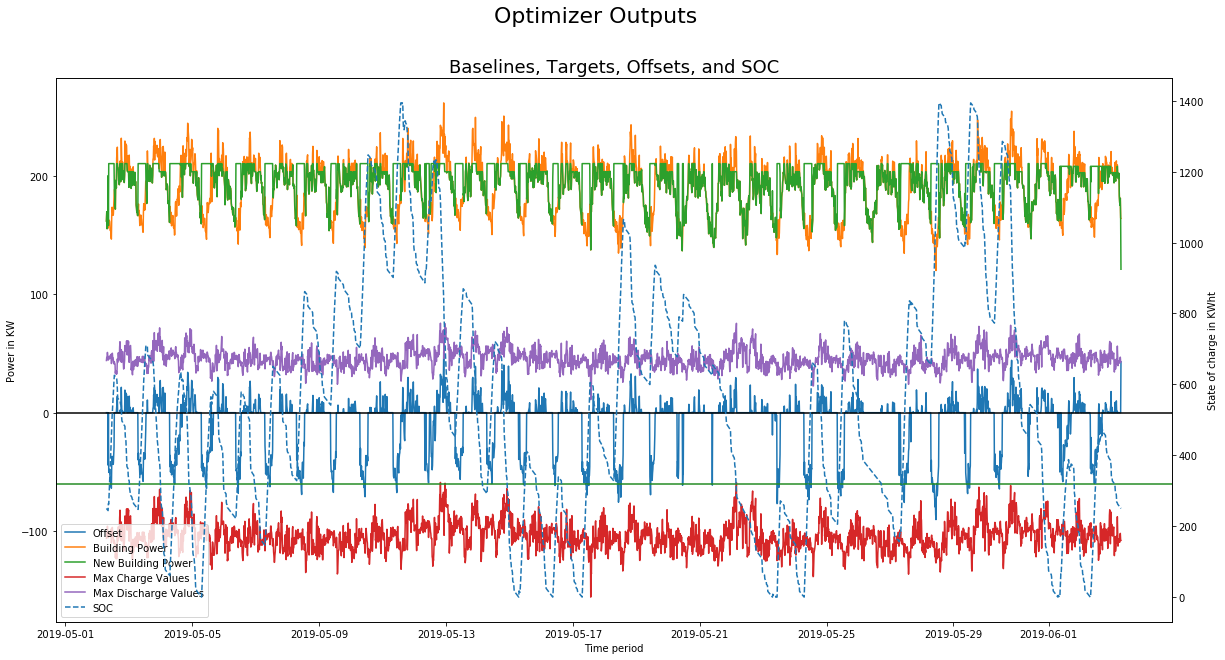

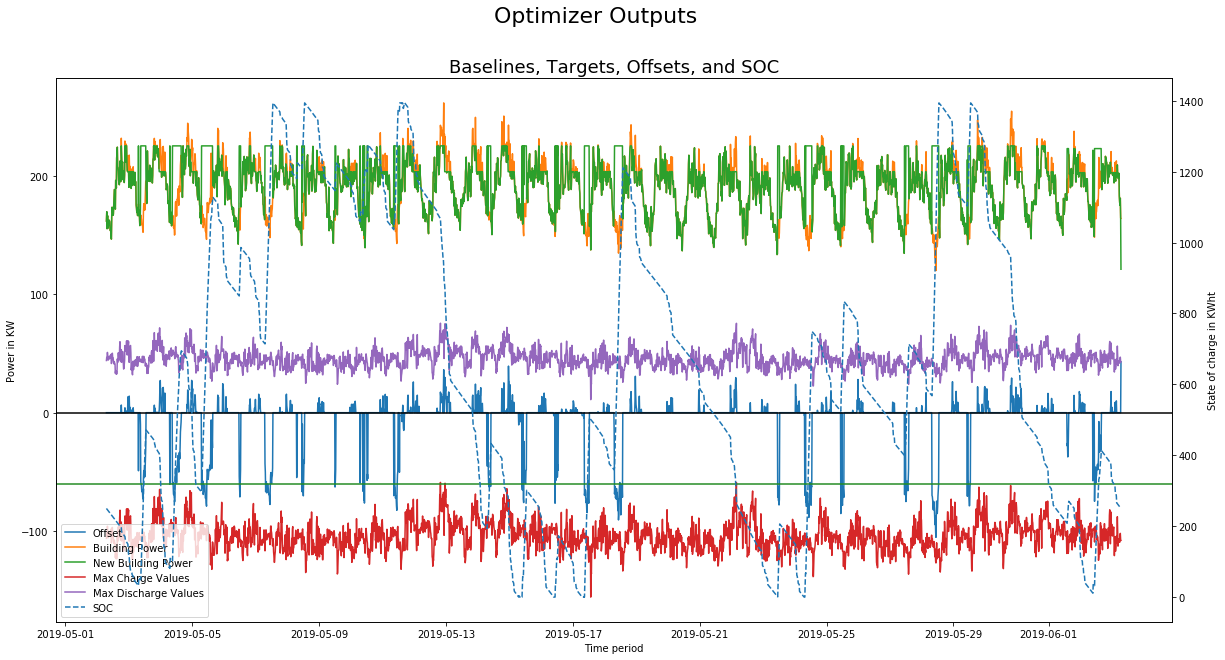

In [25]:
plot(config, targets)
plot(config, derated_targets)

In [26]:
print("Absolute Savings")
display(savings)
print("Derated Ideal Savings")
display(derated_savings_outputs)

for season in actual_savings_tables:
    print("Actual Savings for", season.capitalize())
    display(actual_savings_tables[season])
    print("Ideal Savings for", season.capitalize())
    display(ideal_savings_tables[season])
    print("Derated Ideal Savings for", season.capitalize())
    display(derated_ideal_savings_tables[season])

Absolute Savings


,ideal_demand,actual_demand,ideal_energy,actual_energy,ideal_total,actual_total,ideal_rte,actual_rte
,1718.78,1482.15,-522.29,-513.88,1196.49,968.26,0.25,0.38


Derated Ideal Savings


,ideal_demand,actual_demand,ideal_energy,actual_energy,ideal_total,actual_total,ideal_rte,actual_rte
,1395.97,1482.15,-355.18,-513.88,1040.79,968.26,0.2,0.38


Actual Savings for Summer


,Rate,Baseline,Actual,Change From Baseline,Savings
Mid-Peak Energy,0.12,1947.77,2056.46,108.69,-12.99
Non-Coincident Demand,24.23,238.03,216.22,-21.81,528.52
Off-Peak Energy,0.10,5201.47,5609.36,407.89,-40.13
On-Peak Demand,17.42,220.86,204.25,-16.61,289.40
On-Peak Energy,0.14,2043.86,1986.48,-57.38,8.06


Ideal Savings for Summer


,Rate,Baseline,Ideal,Change From Baseline,Savings
Mid-Peak Energy,0.12,1947.77,1929.22,-18.56,2.22
Non-Coincident Demand,24.23,238.03,208.38,-29.65,718.43
Off-Peak Energy,0.10,5201.47,5684.02,482.55,-47.48
On-Peak Demand,17.42,220.86,202.98,-17.88,311.44
On-Peak Energy,0.14,2043.86,2007.70,-36.16,5.08


Derated Ideal Savings for Summer


,Rate,Baseline,Derated Ideal,Change From Baseline,Savings
Mid-Peak Energy,0.12,1947.77,1937.02,-10.76,1.29
Non-Coincident Demand,24.23,238.03,223.38,-14.65,354.98
Off-Peak Energy,0.10,5201.47,5458.90,257.43,-25.33
On-Peak Demand,17.42,220.86,202.98,-17.88,311.44
On-Peak Energy,0.14,2043.86,2007.70,-36.16,5.08


Actual Savings for Winter


,Rate,Baseline,Actual,Change From Baseline,Savings
Mid-Peak Energy,0.11,62697.21,63282.91,585.70,-66.46
Non-Coincident Demand,21.34,262.02,219.30,-42.72,911.54
Off-Peak Energy,0.10,43496.29,48870.70,5374.41,-535.53
On-Peak Demand,16.98,243.24,207.02,-36.21,614.89
On-Peak Energy,0.13,30679.42,29621.89,-1057.53,133.16


Ideal Savings for Winter


,Rate,Baseline,Ideal,Change From Baseline,Savings
Mid-Peak Energy,0.11,62697.21,61879.55,-817.66,92.78
Non-Coincident Demand,21.34,262.02,210.67,-51.34,1095.67
Off-Peak Energy,0.10,43496.29,50165.25,6668.96,-664.53
On-Peak Demand,16.98,243.24,203.84,-39.40,669.04
On-Peak Energy,0.13,30679.42,29967.53,-711.89,89.64


Derated Ideal Savings for Winter


,Rate,Baseline,Derated Ideal,Change From Baseline,Savings
Mid-Peak Energy,0.11,62697.21,62556.05,-141.16,16.02
Non-Coincident Demand,21.34,262.02,225.67,-36.34,775.57
Off-Peak Energy,0.10,43496.29,47930.77,4434.48,-441.87
On-Peak Demand,16.98,243.24,203.84,-39.40,669.04
On-Peak Energy,0.13,30679.42,29967.53,-711.89,89.64


# High-Level Summary Metrics

### Subcooler Summary
Report the maximum offset the subcooler provided

In [27]:
print("Max SSC Offset during On-Peak:",
      load.loc[load["period"] == "On-Peak"][["crs.offset.rackA.power.kW"]].min()["crs.offset.rackA.power.kW"],
     "kW")

print("Max SSC Offset:", load[["crs.offset.rackA.power.kW"]].min()["crs.offset.rackA.power.kW"], "kW")

Max SSC Offset during On-Peak: -8.582637973104207 kW
Max SSC Offset: -8.932001916875501 kW


### CHG & DCHG mode summary data
Collect all of the DCHG and CHG mode data to report high-level "fun facts" in a savings report.

In [28]:
print("Max kW offset in a DCHG session:", load[["building.offset.kW"]].min()["building.offset.kW"], "kW")

Max kW offset in a DCHG session: -52.973509616748956 kW


In [29]:
discharge_sessions = load.loc[load["rbCur_num"].isin([-1, -0.5])]
discharge_sessions["Discharge Session #"] = None
charge_sessions = load.loc[load["rbCur_num"].isin([1, 0.5])]
iterator = 1
previous_index = 0
previous_previous_index = 0
for index, row in discharge_sessions.iterrows():
    if previous_previous_index == 0:
        discharge_sessions.loc[index, ["Discharge Session #"]] = 1
        previous_previous_index = previous_index
        previous_index = index
        continue
    
    index_diff = index - previous_index
    prev_index_diff = index - previous_previous_index
    previous_previous_index = previous_index
    previous_index = index
    if index_diff.value / 1e11 > 9:
        if prev_index_diff.value / 1e11 > 45:
            iterator += 1
        
    discharge_sessions.loc[index, ["Discharge Session #"]] = iterator

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Max kWh discharged in a DCHG Session
Iterate through our DataFrame of all of the DCHG sessions and add all of the 15-min offset data in each DCHG session. Store it in a DataFrame and then find the min (biggest negative) value.

In [30]:
discharge_offset_summary = pandas.DataFrame(columns=["Session Discharge Offset"])
for discharge_session_num in range(1, int(discharge_sessions[["Discharge Session #"]].max()) + 1):
    total_sum = discharge_sessions.loc[discharge_sessions["Discharge Session #"] == discharge_session_num,
                                       ["building.offset.kW"]].sum() / 4
    discharge_offset_summary.loc[discharge_session_num] = total_sum[0]
print("Maximum Total Discharge Offset in a single DCHG session:",
      discharge_offset_summary.min()["Session Discharge Offset"], "kWh-e", sep=" ")

Maximum Total Discharge Offset in a single DCHG session: -198.95514100101812 kWh-e


### Total hours CHG/DCHG
Assuming that the discharge_sessions correctly parsed all of the data in the 
original load file and only contains 15 minute intervals where the RB was in 
DCHG mode, we should just be able to multiply the length of the dataframe by
1/4 in order to return the total number of hours the RB was in DCHG. A quick
reality check shows that there are 720 hours in a 30-day month.

In [31]:
print("Total DCHG Hours in Billing Period:", len(discharge_sessions) / 4, "h")
print("total CHG Hours in Billing Period:", len(charge_sessions) / 4, "h")

Total DCHG Hours in Billing Period: 444.25 h
total CHG Hours in Billing Period: 243.5 h


### RTE
From this link, showing the beginning of the billing period: 

https://plots.axiomxrg.io/d/LOsujaAmk/wmec-dchg?orgId=1&from=1556780400000&to=1556787600000&panelId=22&fullscreen.

and this link, showing the end of the billing period: 

https://plots.axiomxrg.io/d/huktQwtmz/wmec-chg?orgId=1&from=1559541600000&to=1559545199000&panelId=22&fullscreen

it is demonstrable that the state of charge at the beginning and end of the billing period were actually remarkably close, given Hx.HTF.out.T traces. Therefore, the calculated RTE from the tariff library can be used for the actual RTE.

In [34]:
print("RTE:", savings["actual_rte"][0])

RTE: 0.38
